# **Analysis of Food.com Recipes**
Menghe Liu, Lai Zhang, Zhenyang Gai, Zizheng Gao, Ziyue Zhou

Dataset Link: https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv

Dataset Source: The dataset we plan to use is scraped from Food.com, and was published by Shuyang Li on Kaggle

### ***Raw Data Profile:***

In total, this dataset includes data on 180K+ of recipes, and 700K+ recipe reviews.  Some examples of variable names are recipe ID, nutrition information, number of steps in recipe, cooking techniques encountered by users…

There are 8 files in the dataset with 49 variables in total. We plan to delete some comparably uncorrelated variables and observations in the data cleaning processes in order to save us some time on loading the data.


### ***Overview:***

The problem that motivates us is to identify different categories of recipes based on their features in order to provide a wider variety of recipe choices for different groups of people. The rationale behind this is that dietary habits and nutrition needs for different demographics are divergent. With the development of the catering industry, the number of recipes keeps growing and it takes a long time to decide what kind of food we should make and what are the ingredients. Also, we want to know how two recipes are close to each other and what are the most common ingredients. For example, some people are interested in recipes with different nutrients, or some are eating healthy or fascinated by junk food. Our recipe analysis will satisfy users with various needs on their daily recipes .


In [ ]:
! pip install afinn
! pip install spacytextblob
! pip install scikit-plot
! pip install umap-learn

     |████████████████████████████████| 52 kB 587 kB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=355c56a6587ccf4b871800034e61f9e27f6bf7358d7e4cfd889126741cc8a1c3
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn
     |████████████████████████████████| 6.0 MB 8.1 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 10.1 MB 19.0 MB/s 
     |████████████████████████████████| 628 kB 35.8 MB/s 
     |████████████████████████████████| 451 kB 54.3 MB/s 
     |████████████████████████████████| 181 kB 60.2 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attemp

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
import plotnine
from wordcloud import WordCloud
import spacy
from spacy import cli
from umap import UMAP
import scipy.cluster.hierarchy as shc


import sys


from afinn import Afinn
from nltk.tokenize import word_tokenize, RegexpTokenizer, WordPunctTokenizer, TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer

In [ ]:
# import dataset
raw_recipes = pd.read_csv("https://raw.githubusercontent.com/zizgao/BA-820/main/RAW_recipes.csv")
raw_interactions = pd.read_csv("https://raw.githubusercontent.com/zizgao/BA-820/main/RAW_interactions.csv")

In [ ]:
raw_interactions.head(3)
#raw_interactions.shape[0]

,user_id,recipe_id,date,rating,review
0,2001676733,531712,2017/8/18,5,This is my third time making this recipe. It's...
1,1803266070,507226,2014/10/25,5,Love it ! Will make this again.
2,2000496795,507226,2015/9/25,0,"This is the best butternut squash recipe ever,..."


In [ ]:
#raw_recipes.shape[0]
raw_recipes.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,5 tacos,500166,20,2549237,2013/5/13,"['weeknight', '30-minutes-or-less', 'time-to-m...","[249.4, 26.0, 4.0, 6.0, 39.0, 39.0, 0.0]",5,"['cook meat', 'add taco seasoning', 'place mea...",costs about $5.00 to make.,"['ground beef', 'taco seasoning', 'taco shells...",9
1,50 chili for the crockpot,501028,345,2628680,2013/5/28,"['course', 'main-ingredient', 'cuisine', 'prep...","[270.2, 19.0, 26.0, 48.0, 52.0, 21.0, 4.0]",4,['combine all ingredients in a 7-quart crockpo...,"first, thank you to *parsley* - chef # 199848 ...","['stewing beef', 'stewing pork', 'white onion'...",22
2,blepandekager danish apple pancakes,503475,50,128473,2013/7/8,"['danish', '60-minutes-or-less', 'time-to-make...","[358.2, 30.0, 62.0, 14.0, 19.0, 54.0, 12.0]",10,"['beat the eggs lightly and add the milk', 'co...",this recipe has been posted here for play in z...,"['eggs', 'milk', 'flour', 'sugar', 'salt', 'cr...",10


# **Data Cleaning and EDA**

## *Nutrition and Food types*

In [ ]:
#Clean outliers in minutes
q3, q1 = np.percentile(raw_recipes.minutes, [75 ,25])
upperbound = raw_recipes.minutes.mean()+10*(q3-q1)
raw_recipes.loc[raw_recipes['minutes']>upperbound,'minutes'] = raw_recipes.minutes.median()

In [ ]:
# split the nutrition
raw_recipes[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']] = raw_recipes['nutrition'].str.split(",",expand=True)

In [ ]:
raw_recipes.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,5 tacos,500166,20,2549237,2013/5/13,"['weeknight', '30-minutes-or-less', 'time-to-m...","[249.4, 26.0, 4.0, 6.0, 39.0, 39.0, 0.0]",5,"['cook meat', 'add taco seasoning', 'place mea...",costs about $5.00 to make.,"['ground beef', 'taco seasoning', 'taco shells...",9,[249.4,26.0,4.0,6.0,39.0,39.0,0.0]
1,50 chili for the crockpot,501028,345,2628680,2013/5/28,"['course', 'main-ingredient', 'cuisine', 'prep...","[270.2, 19.0, 26.0, 48.0, 52.0, 21.0, 4.0]",4,['combine all ingredients in a 7-quart crockpo...,"first, thank you to *parsley* - chef # 199848 ...","['stewing beef', 'stewing pork', 'white onion'...",22,[270.2,19.0,26.0,48.0,52.0,21.0,4.0]
2,blepandekager danish apple pancakes,503475,50,128473,2013/7/8,"['danish', '60-minutes-or-less', 'time-to-make...","[358.2, 30.0, 62.0, 14.0, 19.0, 54.0, 12.0]",10,"['beat the eggs lightly and add the milk', 'co...",this recipe has been posted here for play in z...,"['eggs', 'milk', 'flour', 'sugar', 'salt', 'cr...",10,[358.2,30.0,62.0,14.0,19.0,54.0,12.0]


In [ ]:
# clearn the []
raw_recipes['calories'] =  raw_recipes['calories'].apply(lambda x: x.replace('[','')) 
raw_recipes['carbohydrates (PDV)'] =  raw_recipes['carbohydrates (PDV)'].apply(lambda x: x.replace(']','')) 

In [ ]:
# change the type of nutrition to float
raw_recipes[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']] = raw_recipes[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']].astype('float')

In [ ]:
raw_recipes.dtypes

name                    object
id                       int64
minutes                  int64
contributor_id           int64
submitted               object
tags                    object
nutrition               object
n_steps                  int64
steps                   object
description             object
ingredients             object
n_ingredients            int64
calories               float64
total fat (PDV)        float64
sugar (PDV)            float64
sodium (PDV)           float64
protein (PDV)          float64
saturated fat (PDV)    float64
carbohydrates (PDV)    float64
dtype: object

In [ ]:
# drop the unnecessary columns
raw_recipes.drop(['contributor_id','submitted','nutrition'], axis=1,inplace = True)

In [ ]:
raw_recipes.head(3)

,name,id,minutes,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,5 tacos,500166,20,"['weeknight', '30-minutes-or-less', 'time-to-m...",5,"['cook meat', 'add taco seasoning', 'place mea...",costs about $5.00 to make.,"['ground beef', 'taco seasoning', 'taco shells...",9,249.4,26.0,4.0,6.0,39.0,39.0,0.0
1,50 chili for the crockpot,501028,345,"['course', 'main-ingredient', 'cuisine', 'prep...",4,['combine all ingredients in a 7-quart crockpo...,"first, thank you to *parsley* - chef # 199848 ...","['stewing beef', 'stewing pork', 'white onion'...",22,270.2,19.0,26.0,48.0,52.0,21.0,4.0
2,blepandekager danish apple pancakes,503475,50,"['danish', '60-minutes-or-less', 'time-to-make...",10,"['beat the eggs lightly and add the milk', 'co...",this recipe has been posted here for play in z...,"['eggs', 'milk', 'flour', 'sugar', 'salt', 'cr...",10,358.2,30.0,62.0,14.0,19.0,54.0,12.0


In [ ]:
recipe_nutrition = raw_recipes.drop(['tags','steps','description','ingredients','n_ingredients'], axis=1, inplace=False)
recipe_nutrition.head(3)

,name,id,minutes,n_steps,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,5 tacos,500166,20,5,249.4,26.0,4.0,6.0,39.0,39.0,0.0
1,50 chili for the crockpot,501028,345,4,270.2,19.0,26.0,48.0,52.0,21.0,4.0
2,blepandekager danish apple pancakes,503475,50,10,358.2,30.0,62.0,14.0,19.0,54.0,12.0


## *Tags*

In [ ]:
# Tag dtm
pattern = "(?u)\\b[\\w-]+\\b"
cv = CountVectorizer(token_pattern=pattern,max_df=.5,min_df=.01)
dtm = cv.fit_transform(raw_recipes.tags)
recipe_tag = pd.DataFrame(dtm.toarray(),columns=cv.get_feature_names())
recipe_tag['id'] = raw_recipes['id']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
recipe_tag.head(3)

,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,60-minutes-or-less,african,american,appetizers,apples,asian,baking,beans,beef,beginner-cook,berries,beverages,breads,breakfast,brunch,cajun,cakes,caribbean,carrots,casseroles,cheese,chicken,chicken-breasts,chinese,chocolate,christmas,citrus,cocktails,comfort-food,condiments-etc,cookies-and-brownies,copycat,creole,crock-pot-slow-cooker,cuisine,...,rice,salad-dressings,salads,saltwater-fish,sandwiches,sauces,savory,scandinavian,seafood,seasonal,served-hot,shellfish,shrimp,side-dishes,simply-potatoes,small-appliance,snacks,soups-stews,southern-united-states,southwestern-united-states,spicy,squash,steak,stove-top,summer,sweet,taste-mood,technique,thai,thanksgiving,to-go,toddler-friendly,tomatoes,tropical-fruit,vegan,vegetables,vegetarian,very-low-carbs,weeknight,id
0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,500166
1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,501028
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,503475


In [ ]:
#Preparation/  time-to-make/ course/ main-ingredient are meaningless for our analysis
recipe_tag_rank = pd.DataFrame(recipe_tag.set_index('id').sum().sort_values(ascending=False).reset_index())
recipe_tag_rank.columns = ['tag','occurance']
recipe_tag_rank[:10]

,tag,occurance
0,cuisine,2730
1,occasion,2309
2,low-in-something,1946
3,60-minutes-or-less,1853
4,main-dish,1749
5,3-steps-or-less,1470
6,30-minutes-or-less,1415
7,vegetables,1338
8,meat,1292
9,north-american,1268


In [ ]:
tag_plot = recipe_tag_rank[recipe_tag_rank['occurance'] > 1000].sort_values(by='occurance',ascending=False)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


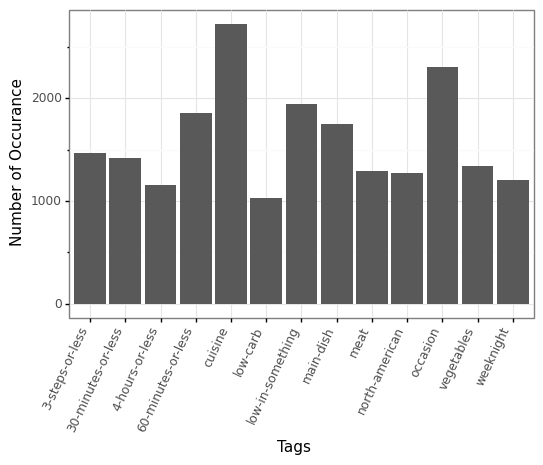

<ggplot: (8731653551541)>

In [ ]:
plotnine.options.dpi = 100
plotnine.options.figure_size=(6,4)
(ggplot(tag_plot)
 + geom_col(aes(x="tag", y="occurance"), show_legend=False)
 + theme_bw()
 + ylab("Number of Occurance")
 + xlab("Tags")
 + theme(axis_text_x=element_text(rotation=65, hjust=1))
)

## *Ingredient*

In [ ]:
# Ingredient dtm
ingr_arr = raw_recipes.ingredients.values
ingr_list = ingr_arr.tolist()
ingr_newlist = []
# initializing punctuations string
punc = '''!()-[]{};:'"\<>./?@#$%^&*_~'''
# Using loop + punctuation string
for item in ingr_list:
  for i in item:
    if i in punc:
        item = item.replace(i, "")
  ingr_newlist.append(item)

ingr_df = pd.DataFrame({'ingredients':ingr_newlist})
ingr_df

,ingredients
0,"ground beef, taco seasoning, taco shells, lett..."
1,"stewing beef, stewing pork, white onion, bell ..."
2,"eggs, milk, flour, sugar, salt, cream, apples,..."
3,"milk, salt, macaroni, cheese, fresh coarse gro..."
4,"ground beef, ground pork, water, cornstarch, w..."
...,...
5823,"zucchini, onion, egg, italian breadcrumbs, gar..."
5824,"extra virgin olive oil, onion, garlic cloves, ..."
5825,"green pepper, mushrooms, onion, butter, zucchi..."
5826,"beef broth, butter, onions, flour, oil, black ..."


In [ ]:
ingr_df["tokens"] = ingr_df.ingredients.str.split(",")
ingr_df1 = ingr_df[['tokens']]
ingr_long = ingr_df1.explode("tokens")
ingr_long.head()

,tokens
0,ground beef
0,taco seasoning
0,taco shells
0,lettuce
0,tomatoes


In [ ]:
ingr_long['value'] = 1
dtm = ingr_long.pivot_table(columns="tokens", 
                           values="value", 
                           index=ingr_long.index,
                           aggfunc=np.count_nonzero)
dtm.fillna(0, inplace=True)
recipe_ingredient = pd.DataFrame(dtm)
ingre_top100 = pd.DataFrame(recipe_ingredient.sum().sort_values(ascending = False).head(100),columns = ['occurance'])
recipe_ingredient['id'] = raw_recipes['id']

In [ ]:
drop = []
for col in recipe_ingredient.columns:
  if recipe_ingredient[col].sum()<55:
    drop.append(col)
recipe_ingredient.drop(drop,inplace = True, axis = 1)

In [ ]:
recipe_ingredient.head(3)

tokens,allpurpose flour,apple cider vinegar,avocado,bacon,baking powder,baking soda,balsamic vinegar,basil,bay leaf,bay leaves,black beans,black pepper,breadcrumbs,brown sugar,butter,buttermilk,canola oil,carrot,carrots,cayenne,cayenne pepper,celery,celery ribs,cheddar cheese,cheese,cherry tomatoes,chicken broth,chicken stock,chickpeas,chili powder,chives,cilantro,cinnamon,cocoa powder,coconut milk,coconut oil,cold water,cooking spray,corn,cornstarch,...,shallot,shallots,sharp cheddar cheese,shredded cheddar cheese,sour cream,soy sauce,sugar,sweet onion,thyme,tomato paste,tomato sauce,tomatoes,turmeric,unsalted butter,vanilla,vanilla extract,vegetable oil,walnuts,warm water,water,white pepper,white sugar,white vinegar,white wine,whole milk,worcestershire sauce,yellow onion,zucchini,allpurpose flour,bacon,butter,eggs,flour,ground beef,olive oil,potatoes,unsalted butter,vegetable oil,water,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,500166
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,501028
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,503475


In [ ]:
# WordCloud

In [ ]:
ingr_arr = raw_recipes.ingredients.values
ingr_list = ingr_arr.tolist()
ingr_newlist = []
# initializing punctuations string
punc = '''!()-[]{};:'"\<>./?@#$%^&*_~'''
# Using loop + punctuation string
for item in ingr_list:
  for i in item:
    if i in punc:
        item = item.replace(i, "")
  ingr_newlist.append(item)

In [ ]:
def listToString(s): 
    str1 = " " 
    return (str1.join(s))
          
ingr_str = listToString(ingr_newlist)

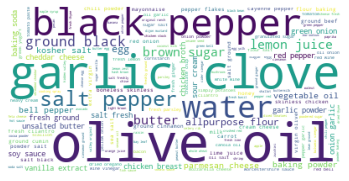

In [ ]:
# WordCould
wc = WordCloud(background_color="white")
wordcloud = wc.generate(ingr_str)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

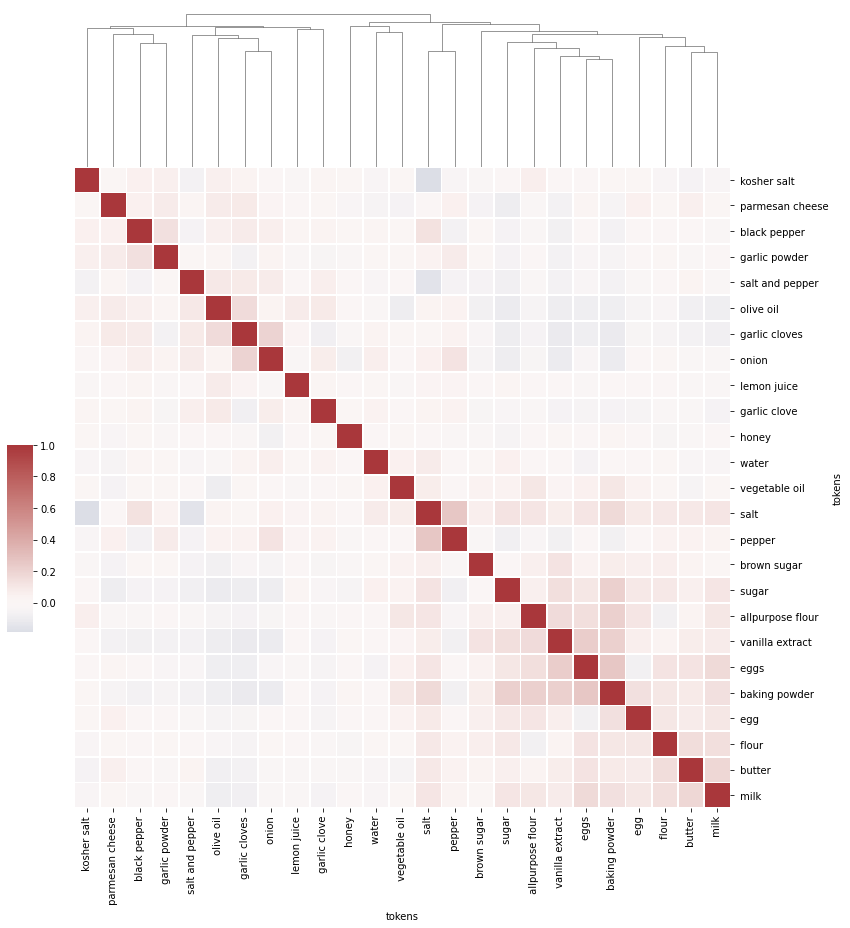

In [ ]:
# Review
ingre_top100 = ingre_top100.reset_index().tokens[:25]
df = recipe_ingredient[ingre_top100].corr()
# Draw the full plot
g = sns.clustermap(df, center=0, cmap="vlag",
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75, figsize=(12, 13))

g.ax_row_dendrogram.remove()

## *Rating and Steps*

In [ ]:
recipe_rating = raw_interactions.groupby('recipe_id').agg({'rating':'mean','review':'count'})
recipe_inter = raw_recipes.merge(recipe_rating, left_on = 'id',right_on='recipe_id',how='outer')
recipe_inter.sort_values("review",ascending=False).head(3)

,name,id,minutes,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),rating,review
3363,mile high cabbage pie 5fix,497021,60,"['weeknight', '60-minutes-or-less', 'time-to-m...",17,"['pre-heat oven to 350f', 'in stockpot , brown...",5-ingredient fix contest entry.\r\n have you ...,"['lean ground beef', 'coleslaw mix', 'simply p...",5,803.0,51.0,42.0,70.0,97.0,53.0,25.0,4.590551,127.0
26,2 ingredients eggs banana pancakes,501408,10,"['15-minutes-or-less', 'time-to-make', 'course...",3,"['mash ripe banana well , add in whisk eggs', ...",i saw this in in a yahoo health list today.,"['eggs', 'banana', 'cooking spray']",3,248.0,15.0,59.0,5.0,27.0,16.0,9.0,3.411111,90.0
4994,spinach and cheese stuffed chicken breast rsc,495271,40,"['weeknight', '60-minutes-or-less', 'time-to-m...",7,['butterfly chicken breast and drizzle with ol...,"ready, set, cook! hidden valley contest entry....","['boneless skinless chicken breasts', 'olive o...",9,409.4,31.0,6.0,33.0,82.0,33.0,5.0,4.144444,89.0


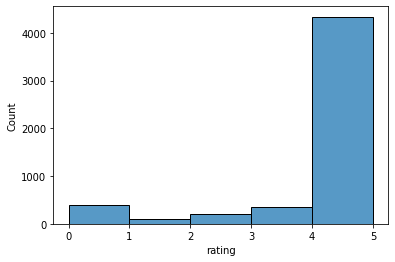

In [ ]:
# Rating
sns.histplot(data = recipe_inter, x = 'rating', bins = 5)

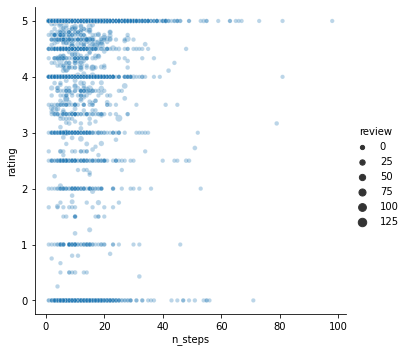

In [ ]:
# Steps
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.relplot(x = 'n_steps', y = 'rating', data = recipe_inter, size = 'review', alpha = .3)

In [ ]:
raw_interactions.head(3)

,user_id,recipe_id,date,rating,review
0,2001676733,531712,2017/8/18,5,This is my third time making this recipe. It's...
1,1803266070,507226,2014/10/25,5,Love it ! Will make this again.
2,2000496795,507226,2015/9/25,0,"This is the best butternut squash recipe ever,..."


In [ ]:
import spacy
from spacy import cli
from spacytextblob.spacytextblob import SpacyTextBlob

cli.download("en_core_web_sm")

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
#Sentiment score
afinn = Afinn()

def sentiment(text):
  return afinn.score(text)    

# create a column "sent"
raw_interactions['review'] = raw_interactions['review'].fillna(str(0))
raw_interactions['review'].isnull().sum()
raw_interactions["sent"] = raw_interactions.review.apply(sentiment)
raw_interactions.sent.describe()

count    13247.000000
mean         6.904658
std          5.649807
min        -10.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         51.000000
Name: sent, dtype: float64

In [ ]:
raw_interactions.head(3)

,user_id,recipe_id,date,rating,review,sent
0,2001676733,531712,2017/8/18,5,This is my third time making this recipe. It's...,3.0
1,1803266070,507226,2014/10/25,5,Love it ! Will make this again.,3.0
2,2000496795,507226,2015/9/25,0,"This is the best butternut squash recipe ever,...",5.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


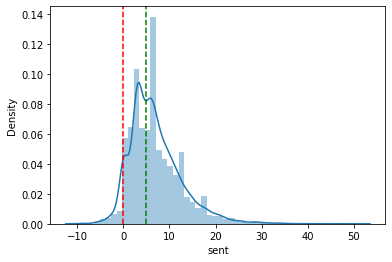

In [ ]:
# distribution of sentiment for customer reviews
sns.distplot(raw_interactions.sent)
plt.axvline(x=5, color='g', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

In [ ]:
raw_interactions["sentiment_v"] = ""

for i, sent in enumerate(raw_interactions["sent"]):
  if sent > 5:
    raw_interactions.sentiment_v[i] = "positive"
  elif sent < 0:
    raw_interactions.sentiment_v[i] = "negative"
  else:
    raw_interactions.sentiment_v[i] = "neutral"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


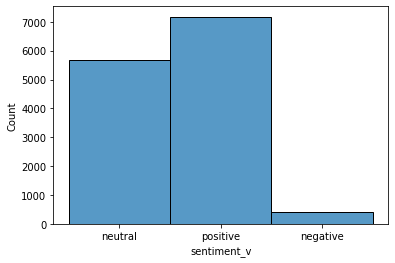

In [ ]:
sns.histplot(x=raw_interactions.sentiment_v)

# **Model Training**

In [ ]:
#Several imports
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA
from sklearn import metrics 
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.metrics import silhouette_samples, silhouette_score
import scikitplot as skplt


In [ ]:
# 1. split nutrition and add the column food type
recipe_nutrition.head(3)

In [ ]:
# 2. dtm tags
recipe_tag.head(3)

In [ ]:
# 3. dtm ingredient
recipe_ingredient.head(3)

In [ ]:
# 4. Sentiment score
raw_interactions.head(3)

,user_id,recipe_id,date,rating,review,sent,sentiment_v
0,2001676733,531712,2017/8/18,5,This is my third time making this recipe. It's...,3.0,neutral
1,1803266070,507226,2014/10/25,5,Love it ! Will make this again.,3.0,neutral
2,2000496795,507226,2015/9/25,0,"This is the best butternut squash recipe ever,...",5.0,neutral


## ***Since we have lots of columns and features, we decided to do clustering multiple times based on different combinations of those features***

## ***1) Clustering based on nutrition and ingredient***

In [ ]:
nutr_ingr = recipe_nutrition.merge(recipe_ingredient, left_on = 'id',right_on='id',how='outer')
nutr_ingr.drop(['name'], axis=1, inplace=True)
nutr_ingr = nutr_ingr.set_index('id')
nutr_ingr.head(3)

,minutes,n_steps,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),allpurpose flour,apple cider vinegar,avocado,bacon,baking powder,baking soda,balsamic vinegar,basil,bay leaf,bay leaves,black beans,black pepper,breadcrumbs,brown sugar,butter,buttermilk,canola oil,carrot,carrots,cayenne,cayenne pepper,celery,celery ribs,cheddar cheese,cheese,cherry tomatoes,chicken broth,chicken stock,chickpeas,chili powder,chives,...,sesame oil,shallot,shallots,sharp cheddar cheese,shredded cheddar cheese,sour cream,soy sauce,sugar,sweet onion,thyme,tomato paste,tomato sauce,tomatoes,turmeric,unsalted butter,vanilla,vanilla extract,vegetable oil,walnuts,warm water,water,white pepper,white sugar,white vinegar,white wine,whole milk,worcestershire sauce,yellow onion,zucchini,allpurpose flour,bacon,butter,eggs,flour,ground beef,olive oil,potatoes,unsalted butter,vegetable oil,water
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
500166,20,5,249.4,26.0,4.0,6.0,39.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
501028,345,4,270.2,19.0,26.0,48.0,52.0,21.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
503475,50,10,358.2,30.0,62.0,14.0,19.0,54.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Utilize uMAP for Dimension reduction 
umap = UMAP(random_state=820)
u = umap.fit_transform(nutr_ingr)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


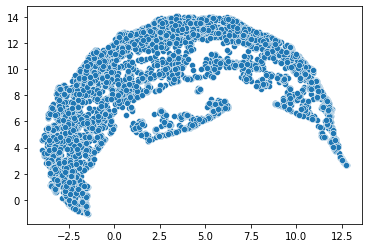

In [ ]:
sns.scatterplot(x=u[:,0], y = u[:,1])

In [ ]:
##################### H cluster
cdist = pdist(u)

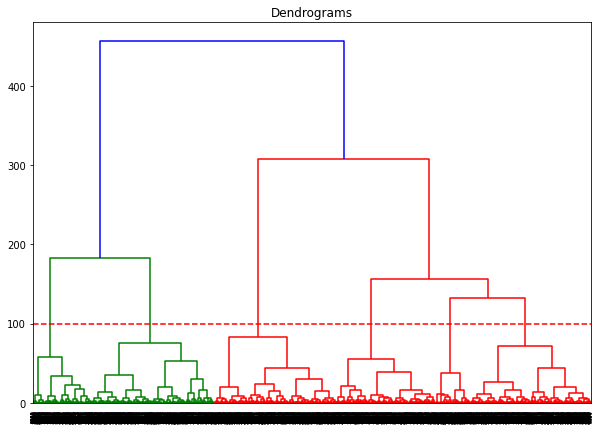

In [ ]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(u, method='ward'))
plt.axhline(y=100, color='r', linestyle='--')

In [ ]:
######## Kmeans

In [ ]:
inertia_list2=[]
silh2 = []
K = range(2,13)
for i in K:
  k = KMeans(n_clusters=i)
  k.fit(u)
  labs = k.predict(u)
  inertia_list2.append(k.inertia_)
  silh2.append(silhouette_score(u, labs))

print(inertia_list2)
print(silh2)

[95615.390625, 55392.21875, 38954.28125, 29877.330078125, 22673.34765625, 17811.203125, 15032.84375, 13222.1484375, 11765.138671875, 10503.44921875, 9291.1015625]
[0.48073676, 0.4627642, 0.43501118, 0.42396674, 0.46635115, 0.45517904, 0.4338322, 0.4201396, 0.42867404, 0.41520566, 0.43262357]


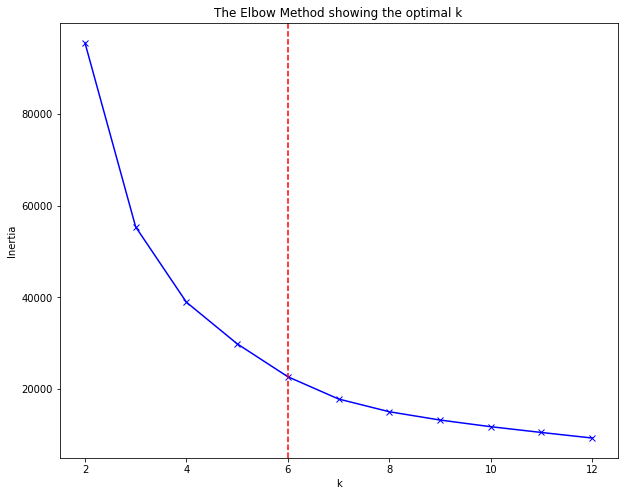

In [ ]:
# elbow plot
plt.figure(figsize=(10,8))
plt.plot(K, inertia_list2, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.axvline(x=6, color='r', linestyle='--')
plt.show()

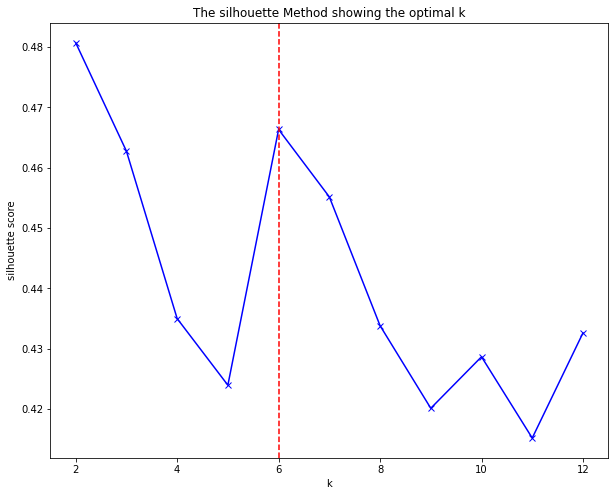

In [ ]:
# silhouette plot
plt.figure(figsize=(10,8))
plt.plot(K, silh2, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('The silhouette Method showing the optimal k')
plt.axvline(x=6, color='r', linestyle='--')

plt.show()

In [ ]:
# fit the cluster with 5
k7 = KMeans(n_clusters=6)
k7.fit(u)

k7_labs = k7.predict(u)
k7_labs

array([3, 4, 0, ..., 1, 2, 1], dtype=int32)

In [ ]:
# put it onto a dataframe

umap_df = pd.DataFrame(u, columns=['u[:,0]', 'u[:,1]'])

umap_df['y'] = k7_labs

umap_df.head(3)

,"u[:,0]","u[:,1]",y
0,-1.927584,9.856657,3
1,4.372660,6.144455,4
2,2.254088,10.659443,0


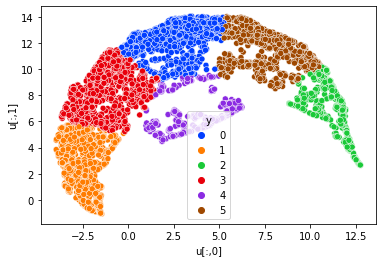

In [ ]:
# plot
PAL = sns.color_palette("bright", 6) 
sns.scatterplot(x="u[:,0]", y="u[:,1]", hue="y", data=umap_df, legend="full", palette=PAL)

In [ ]:
# metrics
k7_silo = silhouette_score(u, k7_labs)
k7_samps = silhouette_samples(u, k7_labs)
np.unique(k7_labs)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [ ]:
hc1=linkage(squareform(cdist), method="ward")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


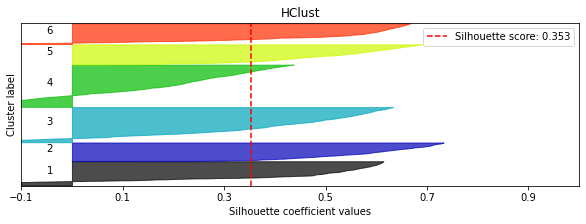

In [ ]:
c1 = fcluster(hc1, 6, criterion="maxclust")
# lets compare via silo
skplt.metrics.plot_silhouette(u, c1, title="HClust", figsize=(10,3))
plt.show()

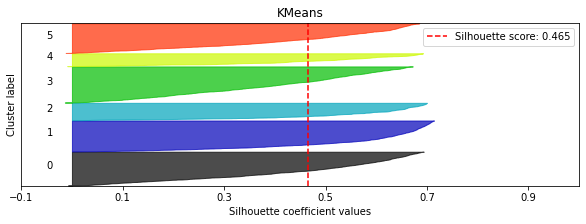

In [ ]:
skplt.metrics.plot_silhouette(u, k7_labs, title="KMeans", figsize=(10,3))
plt.show()

In [ ]:
nutr_ingr['k7_labs'] = k7_labs
cols_to_use = nutr_ingr.columns.difference(raw_interactions.columns)
rating = raw_interactions.groupby('recipe_id').agg({'recipe_id':'count','rating':'mean','sent':'mean'}).set_axis(['review_count','avg_rating','avg_sent'], axis=1)
recipe_full = raw_recipes.merge(rating,left_on='id',right_on='recipe_id',how='left').merge(nutr_ingr[cols_to_use],on='id',how='left')
profile = ['name','id','tags','ingredients','steps','description']
nutr_ingr.groupby('k7_labs').mean()

,minutes,n_steps,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),allpurpose flour,apple cider vinegar,avocado,bacon,baking powder,baking soda,balsamic vinegar,basil,bay leaf,bay leaves,black beans,black pepper,breadcrumbs,brown sugar,butter,buttermilk,canola oil,carrot,carrots,cayenne,cayenne pepper,celery,celery ribs,cheddar cheese,cheese,cherry tomatoes,chicken broth,chicken stock,chickpeas,chili powder,chives,...,sesame oil,shallot,shallots,sharp cheddar cheese,shredded cheddar cheese,sour cream,soy sauce,sugar,sweet onion,thyme,tomato paste,tomato sauce,tomatoes,turmeric,unsalted butter,vanilla,vanilla extract,vegetable oil,walnuts,warm water,water,white pepper,white sugar,white vinegar,white wine,whole milk,worcestershire sauce,yellow onion,zucchini,allpurpose flour,bacon,butter,eggs,flour,ground beef,olive oil,potatoes,unsalted butter,vegetable oil,water
k7_labs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,46.441272,11.934747,385.652692,30.120718,38.942904,27.365416,36.502447,36.313214,10.823817,0.059543,0.007341,0.019576,0.031811,0.056281,0.031811,0.021207,0.012235,0.015498,0.011419,0.018760,0.086460,0.024470,0.066884,0.181892,0.010604,0.030995,0.037520,0.028548,0.011419,0.039152,0.043230,0.013866,0.034258,0.017129,0.013866,0.046493,0.024470,0.012235,0.037520,0.009788,...,0.024470,0.023654,0.022023,0.010604,0.017129,0.055465,0.053018,0.122349,0.013866,0.022023,0.026917,0.025285,0.054649,0.017129,0.040783,0.028548,0.044046,0.060359,0.013866,0.008972,0.135400,0.015498,0.011419,0.009788,0.010604,0.013866,0.032626,0.023654,0.013866,0.013051,0.015498,0.041599,0.015498,0.019576,0.015498,0.054649,0.015498,0.013051,0.012235,0.006525
1,28.588760,9.130241,95.433363,6.170384,19.898305,9.589652,5.625335,7.156111,3.245317,0.039251,0.016057,0.009813,0.012489,0.069581,0.059768,0.019625,0.009813,0.008921,0.001784,0.000892,0.064228,0.007136,0.049955,0.080285,0.017841,0.016057,0.029438,0.021409,0.009813,0.033898,0.021409,0.012489,0.014273,0.009813,0.006244,0.008029,0.003568,0.008029,0.016949,0.014273,...,0.015165,0.011597,0.008029,0.005352,0.005352,0.014273,0.040143,0.172168,0.005352,0.007136,0.009813,0.004460,0.034790,0.008921,0.025870,0.040143,0.045495,0.036574,0.013381,0.013381,0.143622,0.013381,0.012489,0.014273,0.005352,0.004460,0.022302,0.009813,0.013381,0.020517,0.005352,0.044603,0.020517,0.012489,0.000000,0.030330,0.003568,0.007136,0.006244,0.019625
2,76.766667,14.938095,1912.502857,159.473016,407.384127,136.119048,105.255556,192.204762,64.631746,0.122222,0.022222,0.012698,0.031746,0.098413,0.076190,0.012698,0.006349,0.007937,0.009524,0.012698,0.085714,0.019048,0.088889,0.188889,0.030159,0.031746,0.033333,0.025397,0.011111,0.068254,0.023810,0.012698,0.020635,0.015873,0.004762,0.033333,0.039683,0.004762,0.039683,0.014286,...,0.009524,0.014286,0.017460,0.012698,0.015873,0.050794,0.055556,0.211111,0.007937,0.022222,0.026984,0.014286,0.033333,0.011111,0.087302,0.053968,0.096825,0.098413,0.014286,0.014286,0.155556,0.020635,0.017460,0.012698,0.011111,0.020635,0.033333,0.017460,0.012698,0.031746,0.012698,0.049206,0.014286,0.026984,0.015873,0.047619,0.003175,0.030159,0.015873,0.015873
3,37.159664,10.715050,231.903056,16.666921,32.690604,16.881589,19.275783,19.914439,7.255921,0.061879,0.005348,0.012987,0.025974,0.097785,0.076394,0.009167,0.008403,0.012223,0.008403,0.013751,0.059587,0.009931,0.058060,0.149733,0.029794,0.028266,0.035141,0.026738,0.008403,0.036669,0.036669,0.011459,0.022154,0.011459,0.012223,0.030558,0.014515,0.006112,0.032086,0.015279,...,0.012223,0.018335,0.010695,0.018335,0.014515,0.042781,0.037433,0.164248,0.007639,0.005348,0.016807,0.011459,0.032850,0.012987,0.042017,0.047364,0.064935,0.065699,0.019099,0.006112,0.130634,0.010695,0.016807,0.013751,0.006112,0.009167,0.024446,0.012223,0.017571,0.040489,0.011459,0.042781,0.029030,0.016043,0.007639,0.043545,0.012987,0.019099,0.016043,0.012223
4,226.944206,11.351931,276.801502,14.751

## ***2) Clustering based on sentiment and tags***

In [ ]:
sent_tags = rating.merge(recipe_tag, left_on = 'recipe_id',right_on='id',how='outer')
sent_tags.shape

(5828, 153)

In [ ]:
sent_tags = sent_tags.dropna()

In [ ]:
#Utilize uMAP for Dimension reduction 
umap = UMAP(random_state=820)
u1 = umap.fit_transform(sent_tags)

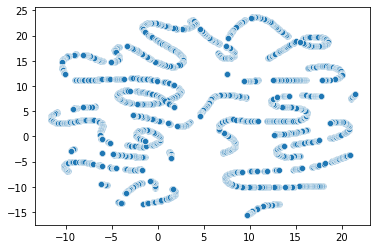

In [ ]:
sns.scatterplot(x=u1[:,0], y = u1[:,1])

In [ ]:
##################### H cluster
udist = pdist(u1)

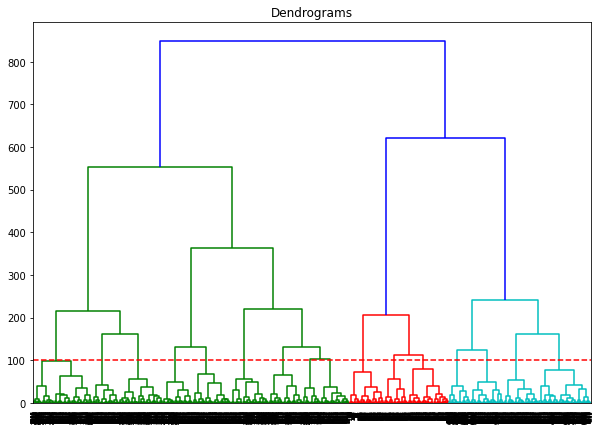

In [ ]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(u1, method='ward'))
plt.axhline(y=100, color='r', linestyle='--')

In [ ]:
######### K means

In [ ]:
inertia_list3=[]
silh3 = []
K = range(2,50,5)
for i in K:
  k = KMeans(n_clusters=i)
  k.fit(u1)
  labs = k.predict(u1)
  inertia_list3.append(k.inertia_)
  silh3.append(silhouette_score(u1, labs))

print(inertia_list3)
print(silh3)

[592217.0, 138362.46875, 72662.140625, 47572.0234375, 35810.4921875, 26838.3125, 20943.919921875, 16794.236328125, 14248.4921875, 11684.728515625]
[0.36130092, 0.3993803, 0.41754663, 0.43516925, 0.4453387, 0.45878735, 0.47614238, 0.4986754, 0.49759814, 0.5226975]


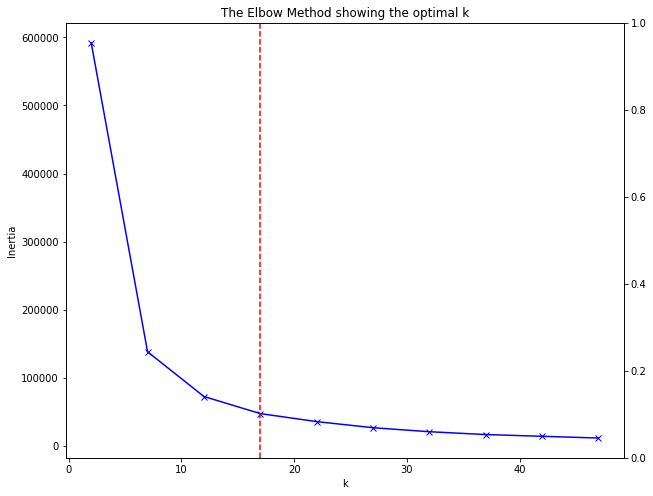

In [ ]:
# elbow plot
plt.figure(figsize=(10,8))
plt.plot(K, inertia_list3, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.axvline(x=17, color='r', linestyle='--')
ax2 = plt.twinx()
plt.show()

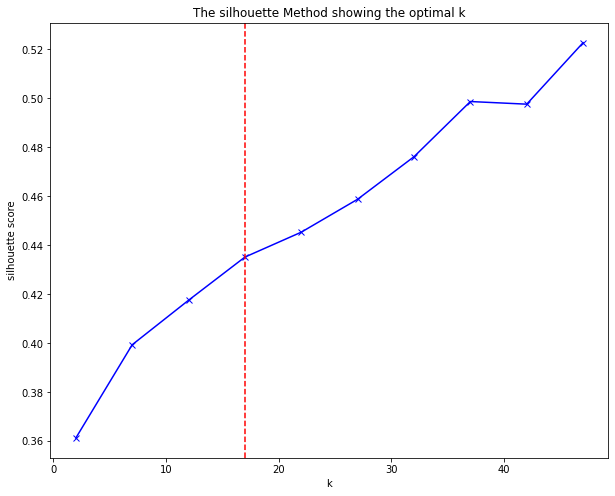

In [ ]:
# silhouette plot
plt.figure(figsize=(10,8))
plt.plot(K, silh3, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('The silhouette Method showing the optimal k')
plt.axvline(x=17, color='r', linestyle='--')

plt.show()

In [ ]:
k17 = KMeans(n_clusters=17)
k17.fit(u1)

k17_labs = k17.predict(u1)
k17_labs

array([16, 16, 16, ...,  6,  6,  6], dtype=int32)

In [ ]:
# put it onto a dataframe

umap_df1 = pd.DataFrame(u1, columns=['u1[:,0]', 'u1[:,1]'])

umap_df1['y1'] = k17_labs

umap_df1.head(3)

,"u1[:,0]","u1[:,1]",y1
0,13.208305,-13.434145,16
1,13.199931,-13.434222,16
2,13.214588,-13.419305,16


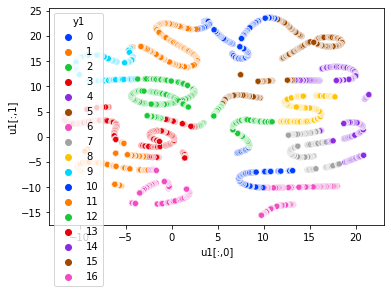

In [ ]:
# plot
PAL1 = sns.color_palette("bright", 17) 
sns.scatterplot(x="u1[:,0]", y="u1[:,1]", hue="y1", data=umap_df1, legend="full", palette=PAL1)

In [ ]:
# metrics
k17_silo = silhouette_score(u1, k17_labs)
k17_samps = silhouette_samples(u1, k17_labs)
np.unique(k17_labs)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32)

In [ ]:
hc2=linkage(squareform(udist), method="ward")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


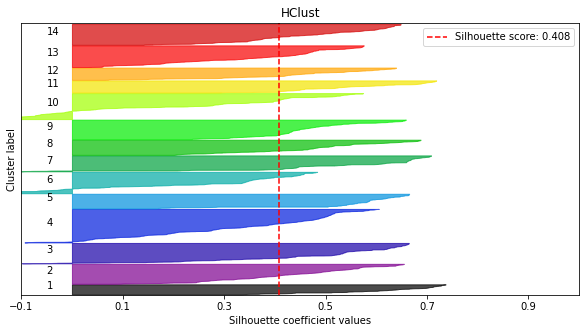

In [ ]:
c2 = fcluster(hc2, 14, criterion="maxclust")
# lets compare via silo
skplt.metrics.plot_silhouette(u1, c2, title="HClust", figsize=(10,5))
plt.show()

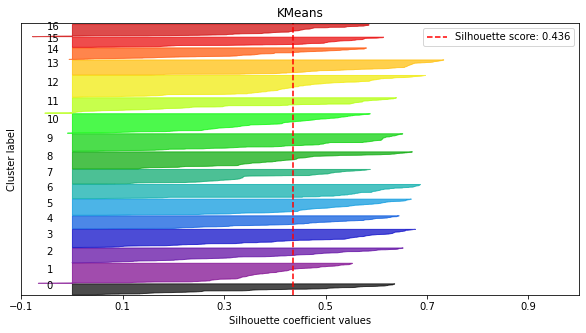

In [ ]:
skplt.metrics.plot_silhouette(u1, k17_labs, title="KMeans", figsize=(10,5))
plt.show()

**Recommendation**

In [ ]:
sent_tags['k17'] = k17_labs
cols = ['review_count','avg_rating','avg_sent','id','k17']
tmp = recipe_full.loc[:,'name':'avg_sent']
tmp['k7'] = recipe_full['k7_labs']
full_profile = tmp.merge(sent_tags[cols],on='id')

**Sample recipes:**


oriental chicken broth</br>
sweet tea baby back ribs





In [ ]:
user_input = input('Please enter a recipe name: ')
input_cluster = [list(full_profile[full_profile['name']==user_input]['k7'])[0],list(full_profile[full_profile['name']==user_input]['k17'])[0]]
recommend = full_profile[(full_profile.k7==input_cluster[0])|(full_profile.k17==input_cluster[1])]
print('Similar recipes recommended for you: ')
recommend[recommend['review_count_x']>3].sort_values(['avg_sent_y','avg_rating_x'],ascending=False)[:10]

Please enter a recipe name: galactic chocolate donuts
Similar recipes recommended for you: 


,name,id,minutes_x,tags,n_steps_x,steps,description,ingredients,n_ingredients,calories_x,total fat (PDV)_x,sugar (PDV)_x,sodium (PDV)_x,protein (PDV)_x,saturated fat (PDV)_x,carbohydrates (PDV)_x,review_count_x,avg_rating_x,avg_sent_x,k7,review_count_y,avg_rating_y,avg_sent_y,k17
3666,pepper steak ponzu,495284,260,"['course', 'soups-stews']",14,"['in a skillet warm the olive oil', 'add in sl...",a wonderful crock-pot meal that goes together ...,"['olive oil', 'round steak', 'ponzu sauce', 'k...",15,294.8,24.0,36.0,9.0,50.0,27.0,4.0,6.0,5.000,17.000,6,6.0,5.000,17.000,14
1517,creole watermelon feta salad,536729,10,"['15-minutes-or-less', 'time-to-make', 'course...",4,['1: arrange watermelon on large platter or in...,spicy watermelon salad. from tony chachere's s...,"['seedless watermelon', 'blueberries', 'avocad...",5,270.4,12.0,157.0,7.0,12.0,14.0,16.0,4.0,4.750,17.000,6,4.0,4.750,17.000,6
3518,overnight refrigerator waffles with dutch honey,502544,500,"['course', 'preparation', 'occasion', 'pancake...",12,"['waffles:', 'dissolve the yeast and sugar in ...",this is an easy recipe that you throw together...,"['dry yeast', 'sugar', 'warm water', 'all-purp...",11,240.6,13.0,83.0,3.0,8.0,17.0,12.0,4.0,5.000,16.500,6,4.0,5.000,16.500,4
4434,slow cooker chicken marrakesh,502948,265,"['curries', 'weeknight', 'course', 'main-ingre...",3,"['place the onion , garlic , carrots , sweet p...",i have been making this moroccan-style recipe ...,"['onion', 'garlic cloves', 'carrots', 'sweet p...",13,244.4,5.0,16.0,25.0,56.0,3.0,7.0,4.0,4.250,13.250,6,4.0,4.250,13.250,4
487,bbq sauce sweet and spicy,510968,12,"['weeknight', '15-minutes-or-less', 'time-to-m...",9,['combine all ingredients except red pepper fl...,"if i have the time to make homemade bbq sauce,...","['catsup', 'granulated sugar', 'apple cider vi...",7,389.3,0.0,377.0,153.0,4.0,0.0,32.0,5.0,4.600,12.200,6,5.0,4.600,12.200,9
1814,easy pepper steak,497758,135,"['weeknight', 'time-to-make', 'course', 'main-...",21,['slice the onion and green bell pepper into 1...,"this is a delicious, easy recipe that will be ...","['beef round steak', 'vegetable oil', 'onion',...",10,117.7,11.0,28.0,73.0,5.0,4.0,4.0,8.0,4.625,12.125,6,8.0,4.625,12.125,0
1336,columbian gone in a flash potato and cheese br...,510766,240,"['time-to-make', 'course', 'main-ingredient', ...",3,['add all ingredients except the tomato in the...,"entered for safe-keeping, from ""the best bread...","['active dry yeast', 'bread flour', 'mashed po...",11,104.0,1.0,2.0,10.0,6.0,1.0,6.0,4.0,5.000,11.500,6,4.0,5.000,11.500,9
4500,soft and creamy slow cooker potatoes,508640,370,"['weeknight', 'course', 'main-ingredient', 'cu...",5,"['add your whole potatoes , soup , water and s...","crack into these soft, creamy, fluffy potatoes...","['potatoes', 'cream of celery soup', 'water', ...",5,215.1,5.0,10.0,15.0,10.0,4.0,14.0,4.0,4.750,11.500,6,4.0,4.750,11.500,1
4603,spicy mini pork kabobs,512195,285,"['course', 'main-ingredient', 'preparation', '...",9,['in medium nonmetal bowl or 1-gallon resealab...,"this is out of my ""c'mon over!"" pillsbury cook...","['garlic clove', 'chili powder', 'ground coria...",7,100.7,8.0,0.0,1.0,23.0,5.0,0.0,4.0,4.750,10.750,6,4.0,4.750,10.750,9
2389,hawaiian shrimp truck special garlic lemon bu...,536051,165,"['time-to-make', 'course', 'cuisine', 'prepara...",13,['add the shrimp to a gallon size ziplock bag ...,caramelized garlic and lemon with a little spi...,"['raw shrimp', 'olive oil', 'lemons, juice of'...",9,249.3,32.0,1.0,22.0,21.0,43.0,1.0,4.0,5.000,10.250,6,4.0,5.000,10.250,6
